In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_2D(a, mu, ndt, sigma_a, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    
    return ndt+rt, theta, np.random.normal(a(rt), sigma_a)

In [3]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    if 2*np.sqrt(a(t)*z)/(sigma*(t-tau))<=700:
        term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    else:
        term1 = 1./(sigma*(t - tau))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = ive(q/sigma-1, (a(t) + z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * ive(q/sigma, (a(t) + z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, sigma=2, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q, sigma)

        for j in range(1, n):
            if a(j*dt) == 0:
                continue
            
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q, sigma)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [4]:
def HSDM_2D_likelihood(prms, RT, Theta, Z):
    a = lambda t: prms[0]/(1 + prms[1]*t)
    a2 = lambda t: (a(t))**2
    da2 = lambda t: -2*prms[1]*prms[0]/(1 + prms[1]*t)**2 * a(t)
    
    ndt = prms[2]
    mu = np.array([prms[3], prms[4]])
    sig = prms[5]
        
    T_max = min(max(RT), prms[0]/prms[1])
    fpt = ie_bessel_fpt(a2, da2, mu.shape[0], 0.000001, 
                        dt=0.05, T_max=T_max)
        
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.0001 and rt - ndt < T_max:
            mu_dot_x0 = mu[0]*np.cos(theta)
            mu_dot_x1 = mu[1]*np.sin(theta)
            term1 = a(rt - ndt) * (mu_dot_x0 + mu_dot_x1)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt - ndt)

            density = np.exp(term1 - term2) * fpt(rt - ndt)
            
            if 0.1**14 < density:
                log_lik += -np.log(density) + 0.5*(Z[i] - a(rt - ndt))**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
            else:
                log_lik += -np.log(0.1**14) + 0.5*(Z[i] - a(rt - ndt))**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [5]:
recovery_dic = {'b0_true': [],
                'b0_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'ndt_true': [],
                'ndt_estimate': [],
                'mu1_true': [],
                'mu1_estimate': [],
                'mu2_true': [],
                'mu2_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[]}

min_b0 = 2
max_b0 = 5

min_lambda = .1
max_lambda = 2

min_ndt = 0.1
max_ndt = 1

min_mu = -3
max_mu = 3

In [14]:
for n in tqdm(range(15)):
    b0 = np.random.uniform(min_b0, max_b0)
    lamb = np.random.uniform(min_lambda, max_lambda)
    a = lambda t: b0 /(1 + lamb*t)
    
    ndt = np.random.uniform(min_ndt, max_ndt)
    mu = np.array([np.random.uniform(min_mu, max_mu), 
                   np.random.uniform(min_mu, max_mu)])
    
    sigma_a = np.random.uniform(0.05, 0.5)
    
    RT = []
    Theta = []
    Z = []
    
    for i in range(500):
        rt, theta, z = simulate_HSDM_2D(a, mu, ndt, sigma_a)
        RT.append(rt)
        Theta.append(theta)
        Z.append(z)
    
    min_ans = differential_evolution(HSDM_2D_likelihood,
                                     args=(RT, Theta, Z),
                                     bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                                             (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                                             (0.05, 0.5)])
    
    min_ans = minimize(HSDM_2D_likelihood,
                       args=(RT, Theta, Z),
                       method='nelder-mead',
                       x0=min_ans.x,
                       bounds=[(min_b0, max_b0), (min_lambda, max_lambda),
                               (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                               (0.05, 0.5)])
    
    if min_ans.success:
        recovery_dic['b0_true'].append(b0)
        recovery_dic['lambda_true'].append(lamb)
        recovery_dic['ndt_true'].append(ndt)
        recovery_dic['mu1_true'].append(mu[0])
        recovery_dic['mu2_true'].append(mu[1])
        recovery_dic['sigma_true'].append(sigma_a)

        recovery_dic['b0_estimate'].append(min_ans.x[0])
        recovery_dic['lambda_estimate'].append(min_ans.x[1])
        recovery_dic['ndt_estimate'].append(min_ans.x[2])
        recovery_dic['mu1_estimate'].append(min_ans.x[3])
        recovery_dic['mu2_estimate'].append(min_ans.x[4])
        recovery_dic['sigma_estimate'].append(min_ans.x[5])

100%|███████████████████████████████████████████| 15/15 [16:24<00:00, 65.61s/it]


In [15]:
recovery_df = pd.DataFrame(recovery_dic)
recovery_df.corr()

,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate
b0_true,1.000000,0.977824,0.236189,0.236071,-0.173596,-0.172529,-0.017950,-0.019531,0.066869,0.070813,-0.127766,-0.134202
b0_estimate,0.977824,1.000000,0.116983,0.156554,-0.101238,-0.109810,-0.012618,-0.018740,0.073827,0.079988,-0.137799,-0.145486
lambda_true,0.236189,0.116983,1.000000,0.974889,-0.047246,-0.023130,-0.279428,-0.270564,-0.338627,-0.338470,-0.171863,-0.174269
lambda_estimate,0.236071,0.156554,0.974889,1.000000,0.047837,0.064552,-0.313227,-0.308459,-0.385098,-0.383196,-0.203375,-0.208497
ndt_true,-0.173596,-0.101238,-0.047246,0.047837,1.000000,0.997762,-0.077126,-0.076273,-0.465303,-0.462665,-0.172431,-0.151190
ndt_estimate,-0.172529,-0.109810,-0.023130,0.064552,0.997762,1.000000,-0.078118,-0.075918,-0.470024,-0.468329,-0.159025,-0.137333
mu1_true,-0.017950,-0.012618,-0.279428,-0.313227,-0.077126,-0.078118,1.000000,0.999479,0.181215,0.185722,0.221719,0.214912
mu1_estimate,-0.019531,-0.018740,-0.270564,-0.308459,-0.076273,-0.075918,0.999479,1.000000,0.178191,0.181959,0.215343,0.208853
mu2_true,0.066869,0.073827,-0.338627,-0.385098,-0.465303,-0.470024,0.181215,0.178191,1.000000,0.999181,0.362651,0.353742
mu2_estimate,0.070813,0.079988,-0.338470,-0.383196,-0.462665,-0.468329,0.185722,0.181959,0.999181,1.000000,0.362933,0.353443


In [16]:
recovery_df

,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate
0,2.638623,2.614031,0.399734,0.386515,0.963305,0.961068,-0.275862,-0.250580,-2.361215,-2.406066,0.297276,0.290870
1,4.333779,3.873961,1.813650,1.601590,0.177593,0.226802,1.375688,1.422063,0.406960,0.409023,0.475222,0.439830
2,4.848307,4.791811,0.787443,0.780925,0.416549,0.434154,2.140066,2.211240,0.780254,0.744897,0.239018,0.239470
3,3.885464,3.919783,1.752365,1.782283,0.992321,0.990905,1.411012,1.384396,-2.406998,-2.280300,0.063494,0.066758
4,2.596039,2.161249,1.432034,1.057818,0.136864,0.190866,0.943188,1.007293,0.578583,0.633940,0.413937,0.402013
5,4.028899,4.049988,0.487913,0.496906,0.310516,0.307115,2.991230,3.000000,2.764521,2.786648,0.227983,0.226966
6,3.970938,3.954189,0.893877,0.898850,0.231463,0.237152,0.581806,0.552385,-2.314272,-2.216489,0.097442,0.098427
7,4.988124,5.000000,1.122641,1.106810,0.422980,0.423473,-0.424550,-0.498497,-1.090448,-1.050769,0.431306,0.426838
8,2.511003,2.492870,1.660562,1.712768,0.586252,0.606074,-2.201858,-2.242794,-2.573154,-2.724677,0.090690,0.093022
9,2.984295,2.900804,1.882885,1.889833,0.907454,0.932188,-2.536526,-2.601042,-1.875000,-1.865064,0.329706,0.346505


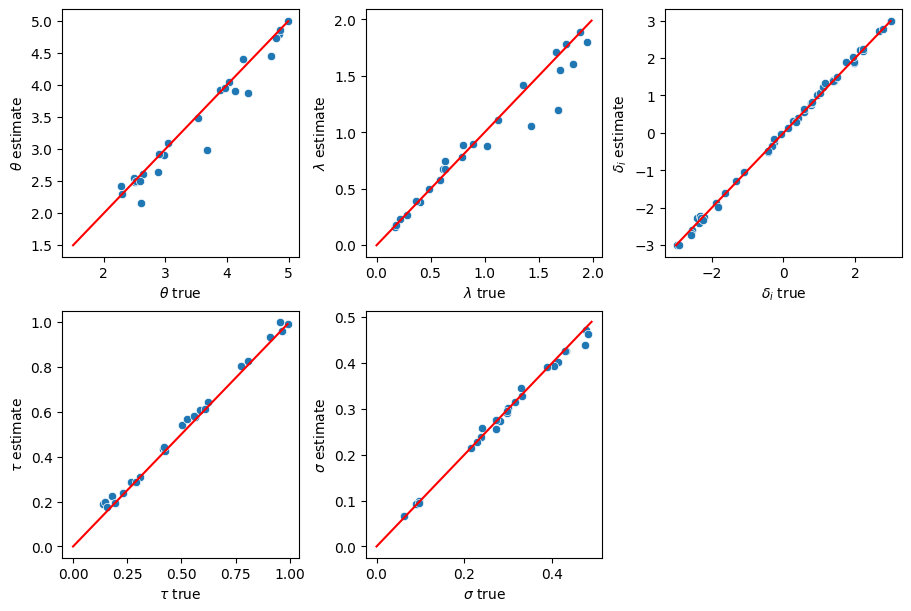

In [19]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 5, 0.01), np.arange(1.5, 5, 0.01), c='red')
sns.scatterplot(x='b0_true', y='b0_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(-3, 3, 0.01), np.arange(-3, 3, 0.01), c='red')
sns.scatterplot(x='mu1_true', y='mu1_estimate', data=recovery_df);
sns.scatterplot(x='mu2_true', y='mu2_estimate', data=recovery_df, c='tab:blue');
plt.xlabel(r'$\delta_i$ true')
plt.ylabel(r'$\delta_i$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate');

plt.subplot(235)
plt.plot(np.arange(0, .5, 0.01), np.arange(0, .5, 0.01), c='red')
sns.scatterplot(x='sigma_true', y='sigma_estimate', data=recovery_df);
plt.xlabel(r'$\sigma$ true')
plt.ylabel(r'$\sigma$ estimate');

In [20]:
recovery_df.corr()

,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate
b0_true,1.000000,0.977824,0.236189,0.236071,-0.173596,-0.172529,-0.017950,-0.019531,0.066869,0.070813,-0.127766,-0.134202
b0_estimate,0.977824,1.000000,0.116983,0.156554,-0.101238,-0.109810,-0.012618,-0.018740,0.073827,0.079988,-0.137799,-0.145486
lambda_true,0.236189,0.116983,1.000000,0.974889,-0.047246,-0.023130,-0.279428,-0.270564,-0.338627,-0.338470,-0.171863,-0.174269
lambda_estimate,0.236071,0.156554,0.974889,1.000000,0.047837,0.064552,-0.313227,-0.308459,-0.385098,-0.383196,-0.203375,-0.208497
ndt_true,-0.173596,-0.101238,-0.047246,0.047837,1.000000,0.997762,-0.077126,-0.076273,-0.465303,-0.462665,-0.172431,-0.151190
ndt_estimate,-0.172529,-0.109810,-0.023130,0.064552,0.997762,1.000000,-0.078118,-0.075918,-0.470024,-0.468329,-0.159025,-0.137333
mu1_true,-0.017950,-0.012618,-0.279428,-0.313227,-0.077126,-0.078118,1.000000,0.999479,0.181215,0.185722,0.221719,0.214912
mu1_estimate,-0.019531,-0.018740,-0.270564,-0.308459,-0.076273,-0.075918,0.999479,1.000000,0.178191,0.181959,0.215343,0.208853
mu2_true,0.066869,0.073827,-0.338627,-0.385098,-0.465303,-0.470024,0.181215,0.178191,1.000000,0.999181,0.362651,0.353742
mu2_estimate,0.070813,0.079988,-0.338470,-0.383196,-0.462665,-0.468329,0.185722,0.181959,0.999181,1.000000,0.362933,0.353443
